In [1]:
from functools import partial
from pathlib import Path

import colorcet as cc
import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from dynamical_systems.analysis import lyapunov_gr
from dynamical_systems.analysis.jacobian import jacobian
from dynamical_systems.continuous import Lorenz63
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    mean_squared_error as mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)
from dynamics_discovery.dataset import TimeSeriesDataset
from dynamics_discovery.io import load_model
from dynamics_discovery.metrics.error import relative_error_norm
from dynamics_discovery.preprocessing import (
    add_noise,
    split_into_chunks,
    standardize,
)
from matplotlib_utils.axes_setters import set_labels
from matplotlib_utils.plots import colored_scatterplot, plot_line_and_band


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_enable_x64", True)

datadir = Path("../../data")
loaddir = Path("../../results/lorenz63_final")

dataset = TimeSeriesDataset.load(datadir / "lorenz63.hdf5").to_numpy()

2025-06-05 14:18:45.101851: W external/xla/xla/service/platform_util.cc:211] unable to create StreamExecutor for CUDA:2: : CUDA_ERROR_OUT_OF_MEMORY: out of memory


In [2]:
train_length = 5
noise = 0.02
key = 0
weight = 1.0

t = dataset.t[0]
u_orig = add_noise(dataset.u[0], noise)
u_test_orig = dataset.u[1:]
u_train, u_test = standardize(u_orig, u_test_orig)
u_std = jnp.std(u_orig, axis=0)

# model = load_model(
#     loaddir / f"len={train_length}_downsample=1_noise={noise}_key={key}.eqx"
# )

model = load_model(
    loaddir
    / f"neighborhood2/len={train_length}_neighbors=25_weight={weight}_noise={noise}_key={key}.eqx"
)
t_train_batch = split_into_chunks(t, train_length)
u_train_batch = split_into_chunks(u_train, train_length)

subsample_factor = u_train_batch.shape[0] // 100
print(t_train_batch.shape)


(2000, 5)


In [10]:
u_test_orig.shape

(10000, 10000, 3)

In [11]:
u_pred_short = eqx.filter_vmap(model.solve)(
    t_train_batch[::subsample_factor], u_train_batch[::subsample_factor, 0]
)
u_pred_long = model.solve(t, u_train[0], max_steps=None)
u_pred_test = model.solve(t, u_test[0, 0], max_steps=None)

Text(0.5, 0.98, 'NeuralODE prediction (train length = 5, seed = 0)')

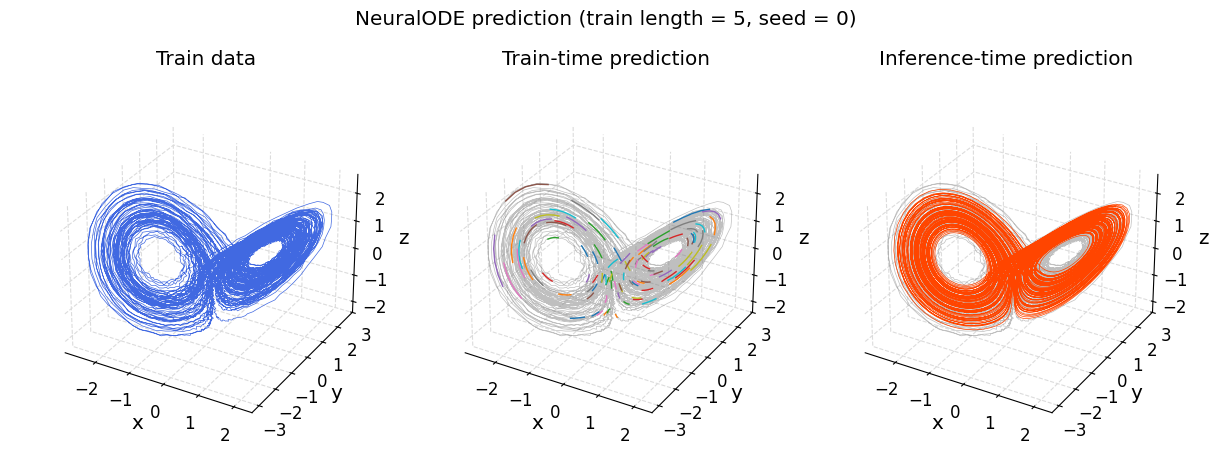

In [13]:
fig, axes = plt.subplots(
    1,
    3,
    figsize=(12, 5),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
plot_kwargs = {"linewidth": 0.5}
axes[0].set_title("Train data")
axes[0].plot(*u_train.T, color="royalblue", **plot_kwargs)

axes[1].plot(*u_train.T, color="gray", alpha=0.5, **plot_kwargs)
for u_i in np.asarray(u_pred_short):
    axes[1].plot(*u_i.T, linewidth=1.0)
axes[1].set_title("Train-time prediction")
axes[2].plot(*u_train.T, color="gray", alpha=0.5, **plot_kwargs)
axes[2].plot(*u_pred_long.T, color="orangered", **plot_kwargs)
axes[2].set_title("Inference-time prediction")

for ax in axes:
    set_labels(ax, ["x", "y", "z"], fontsize="large")
    ax.set_box_aspect(None, zoom=0.85)
fig.suptitle(f"NeuralODE prediction (train length = {train_length}, seed = {key})")

Text(0.5, 0.98, 'NeuralODE prediction (train length = 5, seed = 0)')

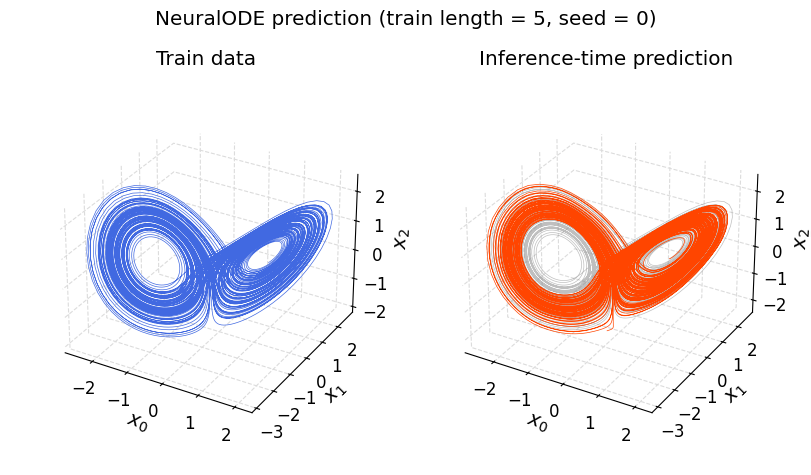

In [4]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(8, 5),
    constrained_layout=True,
    subplot_kw={"projection": "3d"},
)
plot_kwargs = {"linewidth": 0.5}
axes[0].set_title("Train data")
axes[0].plot(*u_test[0].T, color="royalblue", **plot_kwargs)

axes[1].plot(*u_test[0].T, color="gray", alpha=0.5, **plot_kwargs)
axes[1].plot(*u_pred_test.T, color="orangered", **plot_kwargs)
axes[1].set_title("Inference-time prediction")

for ax in axes:
    set_labels(ax, [f"$x_{i}$" for i in range(3)], fontsize="large")
    ax.set_box_aspect(None, zoom=0.85)
fig.suptitle(f"NeuralODE prediction (train length = {train_length}, seed = {key})")


In [8]:
import ott


@eqx.filter_jit
def solve_batch(ode, t, u0_batch, rtol=1e-8, atol=1e-8, **kwargs):
    @partial(ott.utils.batched_vmap, batch_size=5000)
    def _solve(u0):
        sol = dfx.diffeqsolve(
            dfx.ODETerm(ode.rhs),
            dfx.Tsit5(),
            0.0,
            t[-1],
            None,
            u0,
            saveat=dfx.SaveAt(ts=t),
            stepsize_controller=dfx.PIDController(rtol=rtol, atol=atol),
            **kwargs,
        )
        return sol.ys

    return _solve(u0_batch)


In [ ]:
ind_short_term_max = 500
t_short = t[:ind_short_term_max]
t_rescaled_short = np.linspace(0, 10, 1000)[:ind_short_term_max]


def calculate_metric_short(model, metric=mean_squared_error):
    u_pred = solve_batch(model, t_short, u_test[:, 0], max_steps=None)
    return jnp.mean(metric(u_test[:, :ind_short_term_max], u_pred, axis=-1), axis=0)


metric_short = {"vanilla": [], "neighbor": []}
for k in tqdm((0, 10, 20)):
    model = load_model(
        loaddir / f"len={train_length}_downsample=1_noise={noise}_key={k}.eqx"
    )
    metric_short["vanilla"].append(calculate_metric_short(model))

    model2 = load_model(
        loaddir
        / f"neighborhood2/second_order/len={train_length}_neighbors=25_weight={weight}_noise={noise}_key={key}.eqx"
    )
    metric_short["neighbor"].append(calculate_metric_short(model2))

metric_short = jax.tree.map(
    np.asarray,
    metric_short,
)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:13<00:00,  4.37s/it]


Text(0.5, 1.0, 'Train length = 5, Noise = 0.02')

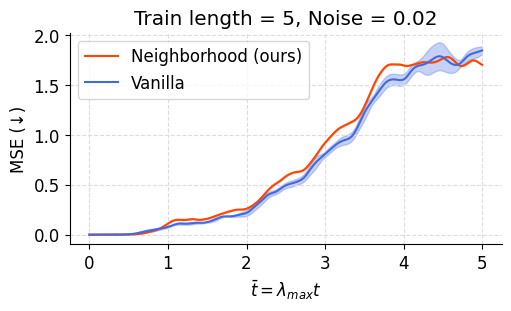

In [10]:
color_dict = {"vanilla": "royalblue", "neighbor": "orangered"}
label_dict = {"vanilla": "Vanilla", "neighbor": "Neighborhood (ours)"}
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for k, v in metric_short.items():
    plot_line_and_band(
        ax,
        t_rescaled_short,
        np.mean(v, axis=0),
        np.std(v, axis=0),
        color=color_dict[k],
        label=label_dict[k],
    )
ax.legend()
ax.set_xlabel(r"$\bar{t}=\lambda_{max}t$")
ax.set_ylabel("MSE (↓)")

ax.set_title(f"Train length = {train_length}, Noise = {noise}")

In [11]:
t_rescaled = np.linspace(0, 100, 10000)
t_idx = jnp.asarray([10, 50, 100, 500, 1000, 5000]) - 1


def calculate_metric_long(model, metric_fn=sinkhorn_divergence):
    u_test_long_pred = solve_batch(model, t[t_idx], u_test[:, 0], max_steps=None)
    metric = []
    for i, t_idx_ in enumerate(t_idx):
        metric.append(metric_fn(u_test[:, t_idx_], u_test_long_pred[:, i]))
    return np.asarray(metric)


metric_long = {"vanilla": [], "neighbor": []}
for k in tqdm((0, 10, 20)):
    model = load_model(
        loaddir / f"len={train_length}_downsample=1_noise={noise}_key={k}.eqx"
    )
    metric_long["vanilla"].append(calculate_metric_long(model))

    model2 = load_model(
        loaddir
        / f"neighborhood/len={train_length}_neighbors=25_weight={weight}_noise={noise}_key={key}.eqx"
    )
    metric_long["neighbor"].append(calculate_metric_long(model2))

for k, v in metric_long.items():
    metric_long[k] = np.stack(v, axis=0)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [02:15<00:00, 45.05s/it]


In [12]:
metric_long["vanilla"].shape

(3, 6)

Text(0.5, 1.0, 'Train length = 5, Noise = 0.02')

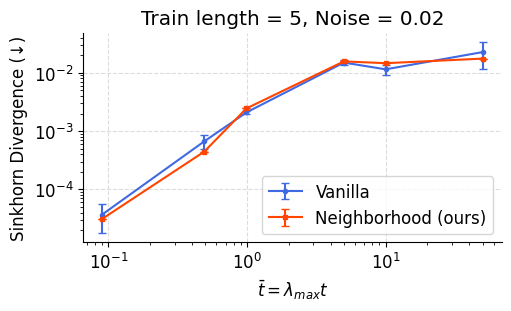

In [13]:
marker_dict = {"vanilla": "o", "neighbor": "s"}

t_rescaled_long = np.asarray([t_rescaled[i] for i in t_idx])
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
for k, v in metric_long.items():
    ax.errorbar(
        t_rescaled_long,
        np.mean(v, axis=0),
        np.std(v, axis=0),
        capsize=3,
        marker=marker_dict[k],
        color=color_dict[k],
        label=label_dict[k],
    )
ax.legend()
ax.set_xlabel(r"$\bar{t}=\lambda_{max}t$")
ax.set_ylabel("Sinkhorn Divergence (↓)")
ax.set_yscale("log", base=10)
ax.set_xscale("log", base=10)
ax.set_title(f"Train length = {train_length}, Noise = {noise}")


In [13]:
u_test_orig.shape

(10000, 3)

In [ ]:
import itertools

train_length = 10
jac_unscaled = jacobian(Lorenz63(), jnp.zeros(u_test_orig.shape[0]), u_test_orig[:, 0])
jac_true = jnp.diag(1 / u_std) @ jac_unscaled @ jnp.diag(u_std)


@eqx.filter_jit
def compute_mean_jac_err(model):
    jac_pred = jacobian(model, jnp.zeros(u_test.shape[0]), u_test[:, 0])
    jac_err = relative_error_norm(jac_pred, jac_true, axis=(-2, -1))
    return jnp.mean(jac_err)


train_lengths = (2, 5, 10)
noises = (0.0, 0.02, 0.05, 0.1)


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1239498/837573218.py:3: SyntaxWarning: invalid escape sequence '\l'
  label_dict = {"vanilla": "Vanilla", "neighbor": "Neighborhood\n($q=1, \lambda=100$)"}
  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:00<00:00, 20.55it/s]


Text(0.5, 0.01, 'Noise strength (%)')

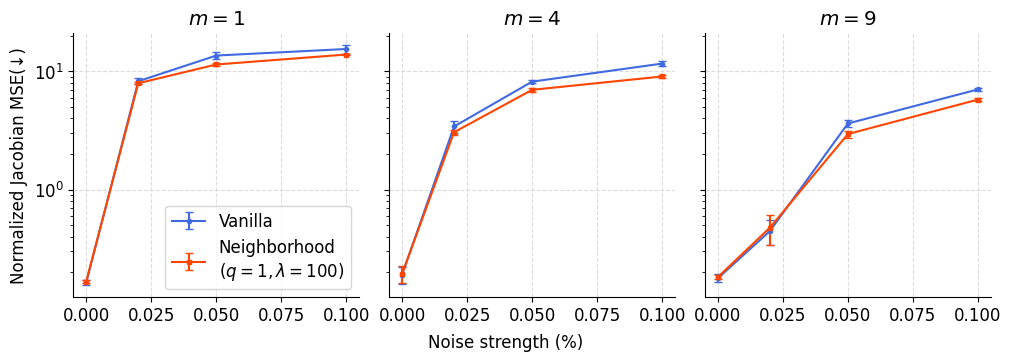

In [6]:
marker_dict = {"vanilla": "o", "neighbor": "s"}
color_dict = {"vanilla": "royalblue", "neighbor": "orangered"}
label_dict = {"vanilla": "Vanilla", "neighbor": "Neighborhood\n($q=1, \lambda=100$)"}

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True, sharex=True)
for i, ax in enumerate(axes):
    jac_errs = {"vanilla": [], "neighbor": []}
    jac_err_neighbor = []
    for n, k in tqdm(list(itertools.product(noises, (0, 10, 20)))):
        model = load_model(
            loaddir / f"len={train_lengths[i]}_downsample=1_noise={n}_key={k}.eqx"
        )
        jac_errs["vanilla"].append(np.asarray(compute_mean_jac_err(model)))

        model2 = load_model(
            loaddir
            / f"neighborhood/len={train_lengths[i]}_neighbors=25_weight={weight}_noise={n}_key={k}.eqx"
        )
        jac_errs["neighbor"].append(np.asarray(compute_mean_jac_err(model2)))

    for k, v in jac_errs.items():
        jac_errs[k] = np.asarray(v).reshape(len(noises), -1)

    for k, v in jac_errs.items():
        ax.errorbar(
            np.asarray(noises),
            np.mean(v, axis=1),
            np.std(v, axis=1),
            capsize=3,
            marker=marker_dict[k],
            color=color_dict[k],
            label=label_dict[k],
        )

    ax.set_yscale("log", base=10)
    ax.set_title(f"$m = {train_lengths[i] - 1}$")
axes[0].set_ylabel("Normalized Jacobian MSE(↓)")
axes[0].legend()
fig.supxlabel("Noise strength (%)", fontsize="medium")

In [24]:
u_orig.shape

(10000, 3)

In [ ]:
# train_length = 10
# noise = 0.05
# key = 10
# weight = 1.0
train_length = 5
noise = 0.0
key = 0
weight = 100.0

t = dataset.t[0]
u_orig = add_noise(dataset.u[0], noise)
u_test_orig = dataset.u[1:]
u_train, u_test = standardize(u_orig, u_test_orig)
u_std = jnp.std(u_orig, axis=0)

jac_unscaled = jacobian(Lorenz63(), jnp.zeros(u_orig.shape[0]), u_orig)
jac_true = jnp.diag(1 / u_std) @ jac_unscaled @ jnp.diag(u_std)

model = load_model(
    loaddir / f"len={train_length}_downsample=1_noise={noise}_key={key}.eqx"
)
jac_nn = jacobian(model, jnp.zeros(u_train.shape[0]), u_train)
err_nn = relative_error_norm(jac_nn, jac_true, axis=(-2, -1))

# model2 = load_model(
#     loaddir
#     / f"neighborhood2/second_order/len={train_length}_neighbors=25_weight={weight}_noise={noise}_key={key}.eqx"
# )
model2 = load_model(
    loaddir
    / f"neighborhood2/first_order/len={train_length}_neighbors=25_weight={weight}_noise={noise}_key={key}.eqx"
)
jac_neighbor = jacobian(model2, jnp.zeros(u_train.shape[0]), u_train)
err_neighbor = relative_error_norm(jac_neighbor, jac_true, axis=(-2, -1))

scatter_kwargs = {
    "s": 1,
    "cmap": cc.cm.rainbow4,
    "vmin": np.percentile(
        np.concatenate((jnp.log10(err_nn), jnp.log10(err_neighbor))), 2.5
    ),
    "vmax": np.percentile(
        np.concatenate((jnp.log10(err_nn), jnp.log10(err_neighbor))), 97.5
    ),
    "alpha": 0.9,
}

fig = colored_scatterplot(
    (u_test[:, 0].T, u_test[:, 0].T),
    (jnp.log10(err_nn), jnp.log10(err_neighbor)),
    figsize=(8, 4),
    **scatter_kwargs,
)
fig.axes[0].set_title("Vanilla", fontsize="medium")
fig.axes[1].set_title("Neighborhood-aware (ours)", fontsize="medium")
fig.axes[-1].set_ylabel(
    r"$\log_{10}||\mathbf{J}_{true}-\mathbf{J}_{pred}||_F\;/\;||\mathbf{J}_{true}||_F$"
)
fig.suptitle(
    f"Relative Jacobian MSE ($m = {train_length - 1}$, noise strength = {noise}%)"
)

NameError: name 'u_orig' is not defined

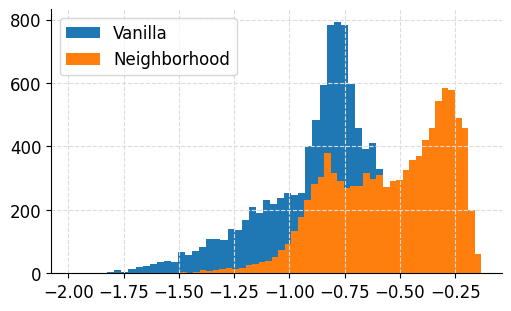

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(np.log10(err_nn), bins=50, label="Vanilla")
ax.hist(np.log10(err_neighbor), bins=50, label="Neighborhood")
ax.legend()

Text(0.5, 0.98, 'Relative Jacobian MSE ($m = 4$, noise strength = 0.02%)')

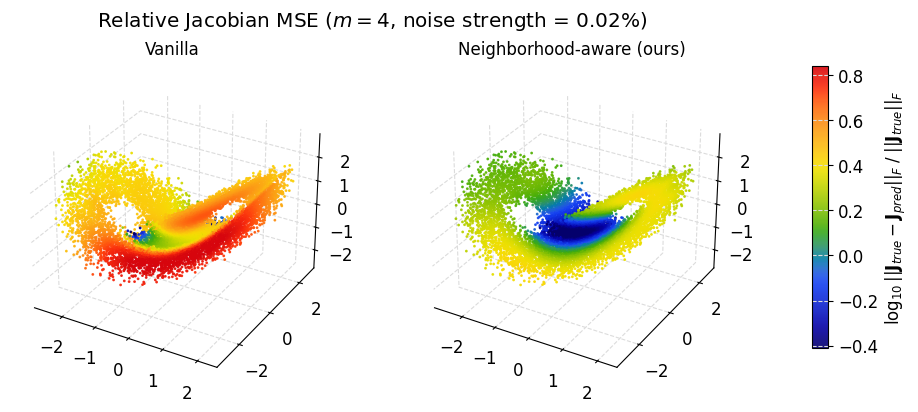

In [3]:
jac_unscaled = jacobian(Lorenz63(), jnp.zeros(u_test_orig.shape[0]), u_test_orig[:, 0])
jac_true = jnp.diag(1 / u_std) @ jac_unscaled @ jnp.diag(u_std)

train_length = 5
noise = 0.02
key = 0
weight = 1.0

model = load_model(
    loaddir / f"len={train_length}_downsample=1_noise={noise}_key={key}.eqx"
)
jac_nn = jacobian(model, jnp.zeros(u_test.shape[0]), u_test[:, 0])
err_nn = relative_error_norm(jac_nn, jac_true, axis=(-2, -1))

model2 = load_model(
    loaddir
    / f"neighborhood2/len={train_length}_neighbors=25_weight={weight}_noise={noise}_key={key}.eqx"
)
jac_neighbor = jacobian(model2, jnp.zeros(u_test.shape[0]), u_test[:, 0])
err_neighbor = relative_error_norm(jac_neighbor, jac_true, axis=(-2, -1))

scatter_kwargs = {
    "s": 1,
    "cmap": cc.cm.rainbow4,
    "vmin": np.percentile(
        np.concatenate((jnp.log10(err_nn), jnp.log10(err_neighbor))), 2.5
    ),
    "vmax": np.percentile(
        np.concatenate((jnp.log10(err_nn), jnp.log10(err_neighbor))), 97.5
    ),
    "alpha": 0.9,
}

fig = colored_scatterplot(
    (u_test[:, 0].T, u_test[:, 0].T),
    (jnp.log10(err_nn), jnp.log10(err_neighbor)),
    figsize=(8, 4),
    **scatter_kwargs,
)
fig.axes[0].set_title("Vanilla", fontsize="medium")
fig.axes[1].set_title("Neighborhood-aware (ours)", fontsize="medium")
fig.axes[-1].set_ylabel(
    r"$\log_{10}||\mathbf{J}_{true}-\mathbf{J}_{pred}||_F\;/\;||\mathbf{J}_{true}||_F$"
)
fig.suptitle(
    f"Relative Jacobian MSE ($m = {train_length - 1}$, noise strength = {noise}%)"
)

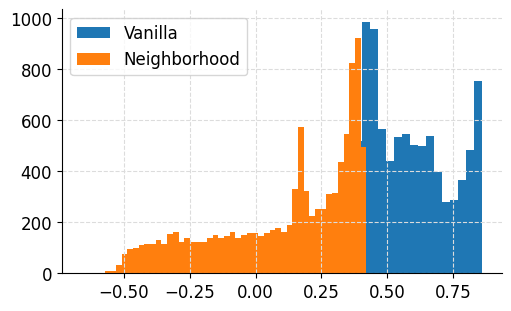

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(np.log10(err_nn), bins=50, label="Vanilla")
ax.hist(np.log10(err_neighbor), bins=50, label="Neighborhood")
ax.legend()

In [5]:
import ott

ind_lya_max = 1000
lya_dict = jnp.load(datadir / "lorenz63_lyapunov.npz")


@eqx.filter_jit
def calculate_lyapunov(model):
    lyas = ott.utils.batched_vmap(
        lambda u0_: lyapunov_gr(
            model, u0_, lya_dict["t"][:ind_lya_max], rtol=1e-8, atol=1e-8, max_steps=64
        )[0],
        batch_size=5000,
    )(u_test[:, 0])
    return lyas

In [6]:
lyapunovs = {"vanilla": [], "neighbor": []}
for k in tqdm((0,)):
    model = load_model(
        loaddir / f"len={train_length}_downsample=1_noise={noise}_key={k}.eqx"
    )
    lyapunovs["vanilla"].append(calculate_lyapunov(model))

    model2 = load_model(
        loaddir
        / f"neighborhood2/len={train_length}_neighbors=25_weight={weight}_noise={noise}_key={key}.eqx"
    )
    lyapunovs["neighbor"].append(calculate_lyapunov(model2))

100%|██████████| 1/1 [07:11<00:00, 431.83s/it]


In [7]:
for k, v in lyapunovs.items():
    lyapunovs[k] = np.stack(v, axis=0)

Text(0.5, 0.98, 'Lyapunov spectrum: train length = 5, noise = 0.02')

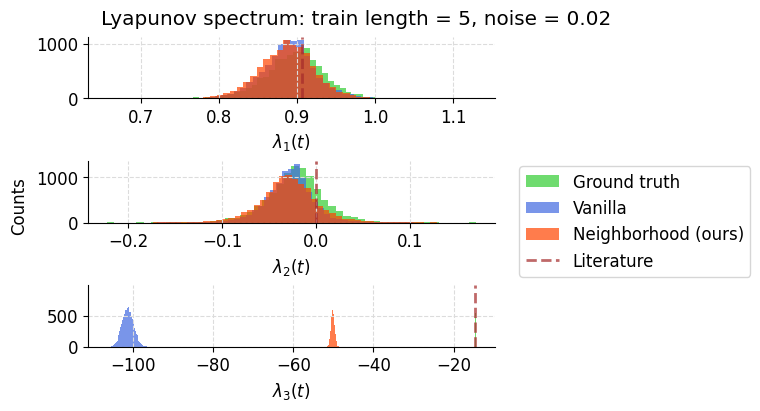

In [9]:
fig, axes = plt.subplots(3, 1, figsize=(7, 4))
color_dict = {"vanilla": "royalblue", "neighbor": "orangered"}
label_dict = {"vanilla": "Vanilla", "neighbor": "Neighborhood (ours)"}
hist_kwargs = {"bins": 50, "alpha": 0.7}
# ax.set_yscale("symlog", base=10)

lya_known = lya_dict["lyas_literature"]
lyas_true = lya_dict["lyas"][:, ind_lya_max - 1]
for i, ax in enumerate(axes.flat):
    ax.hist(
        lyas_true[:, i],
        color="limegreen",
        label="Ground truth",
        **hist_kwargs,
    )
    for k, v in lyapunovs.items():
        ax.hist(
            v[0, :, -1, i],
            color=color_dict[k],
            label=label_dict[k],
            **hist_kwargs,
        )

    ax.axvline(
        x=lya_known[i],
        color="brown",
        linewidth=2.0,
        linestyle="--",
        label="Literature",
        alpha=0.7,
    )
    ax.set_xlabel(rf"$\lambda_{i + 1}(t)$")

axes[1].legend(loc="upper right", bbox_to_anchor=(1.65, 1.05))
fig.supylabel("Counts", fontsize="medium")
fig.align_ylabels()
fig.suptitle(f"Lyapunov spectrum: train length = {train_length}, noise = {noise}")

In [17]:
savedir = Path("../../results_analysis/lorenz63")
np.savez(
    savedir / f"train_length={train_length}_noise={noise}_short.npz", **metric_short
)
np.savez(savedir / f"train_length={train_length}_noise={noise}_long.npz", **metric_long)
np.savez(
    savedir / f"train_length={train_length}_noise={noise}_lyapunov.npz", **lyapunovs
)